In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [268]:
data = pd.read_csv("data.csv")

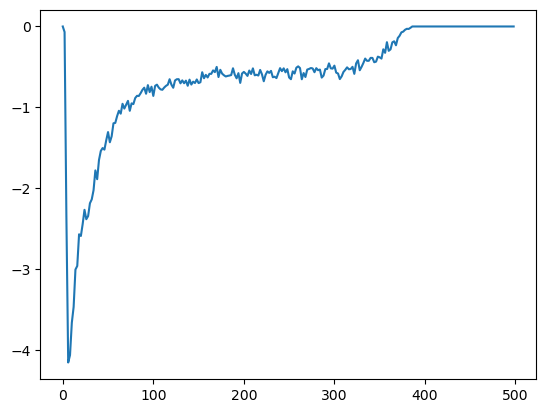

In [271]:
plt.plot(data.t, data.ICaL)
plt.show()